In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 19 10:38:46 2021
@author: mattwear
"""

import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer
import time

### Data Cleaning Functions

# Getting rid of unecesarry columns

def remove_columns(df):
    
    """Removes columns we agreed were useless"""
    columns = ["Unnamed: 0", "id", "image_url", "VIN", "region_url", "id", "size","url"]
    df.drop(columns, axis=1, inplace=True)
    return(df)


def price_range(df, lower = 0, higher = 60_000, sampling = False):
    """
    Set the lower and upper limits of the price, if sampling true it chooses 40,000 samples at random
    """
    if sampling == True:
        df = df.sample(n = 40_000)
    
    df = df.dropna(subset = ["price"])
    
    df = df.loc[df["price"] < higher]
    df = df.loc[df["price"] >= lower]
    
    return(df)

def dateToDatetime(df):
    df['posting_date'] = df['posting_date'].str[:10].astype('datetime64[ns]')
    return df

def basicImpute(df):
    #Here, impute missing values with a common number/value
    
    ###Description: Impute missing values as empty string
    ###posting_date: Not many so impute with mean posting date
    mean_posting_date = np.mean(df.posting_date)

    #Fill NA
    df.fillna(value={'description': '', 'posting_date':mean_posting_date}, inplace=True)
    
    return df


def imputeMissingByManufacturer(df, col):
    ###Impute missing values by taking the most common occurence of the items manufacturer
    #Use this for fuel and transmission. The remaining missing values have NaN manufacturer
    
    cars = df.copy()
    cars_unique = np.unique(cars.manufacturer.astype(str))
    man_dict = {}

    for car in cars_unique:
        if car != 'nan':
            max_occur = cars[cars.manufacturer==car][col].value_counts().index[0]
            man_dict[car] = max_occur

    cars.loc[cars[col].isnull(),col] = cars['manufacturer'].map(man_dict)
    return cars

def imputeManufacturer(cars):
    for item in ['Isuzu','chevrolet',"Willys","Hino","suzuki",'isuzu']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = item
    for item in ['Mustang',"F-150","mustang","f-150","MUSTANG","FORD","ford","Ford","Focus","focus","F-550","f-550","F550","F-350","f-350","F350","expedition el xlt sport","transit"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "ford"
    for item in ['freightliner cascadia 113','freightliner cascadia','freightliner m2 effer','Freightliner M2 112 15','Freightliner','FREIGHTLINER']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "Daimler Trucks North America"
    for item in ['International 4300']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "International DuraStar, America"
    for item in ['Hummer H3',"Hummer H2 SUT","Terrain SLE","HUMMER H2","HUMMER H3","oldsmobile toronado","oldsmobile alero",'h2 hummer']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "General Motors"
    for item in ["MG Midget","mg midget","MG MIDGET","MG"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "MG"
    for item in ["cooper","COOPER","Cooper"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mini"
    for item in ['Scion FR-S',"scion fr-s","SUBARU","subaru","Subaru","forester"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "subaru"
    for item in ['cr-v',"CR-V","crv","CRV","HR-V","hr-v","hrv","HRV","Honda","honda","HONDA","Accord","accord","odyssey","Odyssey","Civic","civic"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "honda"
    for item in ['Maserati',"maserati","MASERATI"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "maserati"
    for item in ['hyundia',"Hyundai","hyundai","HYUNDAI","hyindai",'hyndai',"Hundai","Tucson","tucson","Genesis G80",'genesis G80']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "hyundai"
    for item in ['Mazda',"MAZDA","mazda","cx-5","cx-7","CX-5","CX-7"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mazda"
    for item in ['Isuzu',"ISUZU","isuzu"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "isuzu"
    for item in ['Suzuki',"SUZUKI","suzuki"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "suzuki"
    for item in ['CHRVROLET',"Cheverolet","cheverolet", "cheverolet","chevrolet","Chevrolet","equinox","Cherolet","silverado 1500","tahoe lt","city express",'olet Spark']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "chevrolet"
    for item in ['SCION XB',"scion tc","Scion TC","Scion tc",'Scion XD Hatchback','scion XD Hatchback','scion','Scion',"TOYOTA","toyota","Toyota","yaris","Yaris","YARIS","camry","Camry","CAMRY","corolla",'Corolla',"Civic","civic"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "toyota"
    for item in ['Hudson','hudson']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "hudson motor car"
    for item in ['BMW',"bmw"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "bmw"   
    for item in ['e-class e 350','BENZ','benz','Benz']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mercedes-benz"    
    for item in ['International Durastar Terex','Terrex','terrex']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "terrex"      
    for item in ['freightliner century']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "freightliner truck"
    for item in ['international 4300']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "international harvester company"
    for item in ['patriot','grand cherokee']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "jeep"
    for item in ['leaf sv hatchback 4d','maxima','frontier','note','Note']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "nissan"
    for item in ['Bentley Continental',"bentley continental"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "bentley motors"
    for item in ['KAWASAKI',"kawasaki"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "kawasaki"
    for item in ['wagen Atlas','wagen Passat']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "volkswagen"
    for item in ['73cj5','fuso fe160']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mitsubishi"
    for item in ['LAMBORGHINI','lamborghini','Lamborghini','GALLARDO','gallardo']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "lamborghini"  
    return cars

def imputeOdometerByYear(df):
    #Imputes missing values of odometer with mean odometer for the year the car was made
    odo_dict = df.groupby("year", as_index=True)['odometer'].mean().fillna(np.mean(df.odometer)).to_dict()
    df['odometer'] = df.odometer.fillna(df.year.map(odo_dict))
    return df


def TF_IDF(df, number = 1000):
    
    """This function adds the TF-IDF values of the most important words to the dataframe,
    the number can be chosen above"""
    
    """TF - term frequency """
    
    """Inverse Document Frequency (IDF)
    IDF is a measure of how important a term is"""
    
    vectorizer = TfidfVectorizer(stop_words='english',max_features = number)
    sentences  = df["description"].values
    vectorizer.fit(sentences)
    vector_spaces = vectorizer.transform(sentences)
    tfidf = vector_spaces.toarray()
    
    clf = load('kmeans.joblib') 
    df["tfidf"] = clf.predict(tfidf)
    df = pd.get_dummies(df, prefix="tfidf",columns=['tfidf'])
    
    df.reset_index(drop=True, inplace=True)
    #df = pd.concat([df, pd.DataFrame(tfidf)], axis = 1)
    return(df)


def color_clean(df, color_list=['white','black','silver']):
    #groups all the colors that are not in the list as "other"
    #one hot encoding of paint_color column   
    df["paint_color"]=df["paint_color"].apply(lambda x: x if x in color_list else "other")
    df=pd.get_dummies(df, prefix="color",columns=['paint_color'])
    return df


def cylinder_clean(df):
    df["cylinders"] = df["cylinders"].fillna("missing")
    df = pd.get_dummies(df, columns = ["cylinders"]).drop(\
        ["cylinders_12 cylinders", "cylinders_10 cylinders", "cylinders_3 cylinders", "cylinders_5 cylinders", "cylinders_other"], axis = 1)
    return(df)


def drive_clean(df):
    #Assigns 4wd to all SUVs, pickups and offroads with nan drive type 
    df.loc[(((df["type"]=="SUV") | 
            (df["type"]=="pickup") | 
            (df["type"]=="offroad")) & (df['drive'].isnull()==True)),"drive"] = "4wd"
    #assign "other" to all nan values
    df.loc[(df['drive'].isnull()==True),"drive"]="other"
    #one hot encoding 4wd, rwd, fwd, other
    df = pd.get_dummies(df,prefix="drive",columns=['drive'])
    return df    


def transmission_clean(df):
    #Groups nan values with "other" type of transmission
    df.loc[(df['transmission'].isnull()==True),"transmission"]="automatic"
    #one hot encoding manual, automatic and other
    df = pd.get_dummies(df,prefix="transmission",columns=['transmission'])
    return df


def titlestatus_clean(df):
    df = pd.get_dummies(df,prefix="status",columns=['title_status'])
    return df


def condition_clean(df):
    # nan values to good because average price of nan is close to averag price of good/excellent...
    df.loc[(df['condition'].isnull()==True),"condition"]="good" 
    # good condition -->1    bad condition--->0
    df['condition']=df['condition'].apply(lambda x: 1 if x in ['excellent','good','like new','new'] else 0)
    return df

def fuel_clean(df):
    #group nan values to gas fuel type
    df.loc[(df['fuel'].isnull()==True),"fuel"]="gas"
    #one hot encoding
    df = pd.get_dummies(df,prefix="fuel",columns=['fuel'])
    return df


def fillLatLongNA(df):
    #Fills all missing lat, long values with the median of their respective region
    region_coords_ave_lat = df[['region','lat']].groupby(['region'])['lat'].median().to_dict()
    region_coords_ave_long = df[['region','long']].groupby(['region'])['long'].median().to_dict()
    df.loc[df['lat'].isnull(),'lat'] = df['region'].map(region_coords_ave_lat)
    df.loc[df['long'].isnull(),'long'] = df['region'].map(region_coords_ave_long)
    return df

def fillLatLongOutliers(df):
    latlong_outliers = (df.lat<20)  | (df.lat>70) | (df.long < -160) | (df.long > -60)
    region_coords_ave_lat = df[['region','lat']].groupby(['region'])['lat'].median().to_dict()
    region_coords_ave_long = df[['region','long']].groupby(['region'])['long'].median().to_dict()
    df.loc[latlong_outliers,'lat'] = df['region'].map(region_coords_ave_lat)
    df.loc[latlong_outliers,'long'] = df['region'].map(region_coords_ave_long)
    return df

def cleanLatLong(df):
    df = fillLatLongNA(df)
    df = fillLatLongOutliers(df)
    return df

def cleanLocationFeatures(df):
    df = cleanLatLong(df)
    #one hot encoding state
    df = pd.get_dummies(df,prefix="state",columns=['state'])
    #drop region
    df.drop(['region'], axis=1, inplace=True)
    
    return df  

def groupStateByPrice(df, lower=10000, higher=15000):
    ### Adds binary feature indicating if car was sold in cheap, medium or expensive state
    
    cars = df.copy()
    #Find median price by state
    bar = cars[['price','state']].groupby(['state'])['price'].median()
    bar.sort_values(ascending=False, inplace=True)
    
    #Find expensive, mid price and cheap states according to thresholds
    expensive_states = np.array(bar[bar >higher].index)
    mediumprice_state = np.array(bar[(bar > lower) & (bar <= higher)].index)
    cheap_state = np.array(bar[bar <= lower].index)
    
    #Add on hot encoded features to dataset
    cars['state_expensive'] = cars.state.isin(expensive_states).astype(int)
    cars['state_medium'] = cars.state.isin(mediumprice_state).astype(int)
    cars['state_cheap'] = cars.state.isin(cheap_state).astype(int)
    
    return cars

def cutIQR(cleaned_df, col):
    print('Remove outliers...')

    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    cutted_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]

    return cutted_df, upper


def ohe_manuf_country(cars):
    
    # Manufacturer country assigned
    
    cars.loc[ cars["manufacturer"] == "ford", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "chevrolet", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "toyota", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "honda", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "nissan", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "jeep", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "ram", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "gmc", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "dodge", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "bmw", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "hyundai", "manuf_country"] = "S.Korea"
    cars.loc[ cars["manufacturer"] == "mercedes-benz", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "subaru", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "volkswagen", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "kia", "manuf_country"] = "S.Korea"
    cars.loc[ cars["manufacturer"] == "chrysler", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "lexus", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "cadillac", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "buick", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "mazda", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "audi", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "acura", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "infiniti", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "lincoln", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "pontiac", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "volvo", "manuf_country"] = "Sweden"
    cars.loc[ cars["manufacturer"] == "mini", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "mitsubishi", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "porsche", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "rover", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "mercury", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "saturn", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "tesla", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "jaguar", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "fiat", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "alfa-romeo", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "harley-davidson", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "ferrari", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "datsun", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "aston-martin", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "land-rover", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "morgan", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "hennessey", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"].isnull(), "manuf_country"] = "missing"
    
    # One hot encoding to one of USA, Japan, Germany, S.Korea, UK, Sweden, Italy and missing
    
    cars = pd.get_dummies( cars, columns = ["manuf_country"])
    
    # Manufacturer needs to be dropped
    # There are some imputed manufacturers that are not in this section.
    # These need to be considered as well.
    
    return cars

def ohe_type(cars):
    
    # Some condition groupings
    
    cars.loc[ cars["type"] == "sedan", "usage_type"] = "daily" 
    cars.loc[ cars["type"] == "SUV", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "pickup", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "truck", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "other", "usage_type"] = "other"
    cars.loc[ cars["type"] == "coupe", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "hatchback", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "wagon", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "van", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "convertible", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "mini-van", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "bus", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "offroad", "usage_type"] = "other"
    #---------------------------------------
    # Assumption
    
    #cars.loc[ (cars["type"].isnull()) & (cars["fuel"] == "gas") , "usage_type"] = "daily"
    #---------------------------------------
    cars.loc[ cars["type"].isnull() , "usage_type"] = "missing"
    
    # One hot encoding type (original values)
    
    cars = pd.get_dummies( cars, columns = ["usage_type"])
    
    # Type needs to be dropped
    # Too many values are missing. Don't think we can impute.
    # Maybe we can use the most correlated feature to impute.
    
    return cars

def ultimateClean(df):
    start = time.time()
    #remove useless values
    df = remove_columns(df)
    
    # REMOVE IQR OUTLIERS
#     df = price_range(df, lower = 50, higher = 60_000, sampling = False)
    df, _ = cutIQR(df, 'odometer')
    df, _ = cutIQR(df, 'price')
    print("Cleaned outliers !")

    #impute some missing values
    df = imputeManufacturer(df)
    df = dateToDatetime(df)
    df = basicImpute(df)
    df = imputeMissingByManufacturer(df, col='fuel')
    df = imputeMissingByManufacturer(df, col='transmission')
    df = imputeOdometerByYear(df)
    print("Imputed Missing Values")
    
    #one hot encodings
    df = color_clean(df, color_list=['white','black','silver'])
    df = drive_clean(df)
    df = transmission_clean(df)
    df = titlestatus_clean(df)
    df = cleanLocationFeatures(df)
    df = cylinder_clean(df)
    df = condition_clean(df)
    df = fuel_clean(df)
    df = ohe_type(df)
    df = ohe_manuf_country(df)
    df = TF_IDF(df, number = 1000)
    
    print("One hot encodings done!")
    
    
    
    #remove remaining missing values
    df.drop(['model', "posting_date", "manufacturer", "type", "description"], axis=1, inplace=True)
    
    df = df[df['year'].notna()]
    
    
    df = df.dropna()
    print("Total Time: ", (time.time() - start)/60, " minutes")

    
    return df


def normalise(df):
    cols_to_norm = ["year", "odometer", "lat", "long"]
    df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])
    #FOR TRAIN TEST SPLIT USE SKLEARN train_test_split
    return(df)

In [2]:
cars = pd.read_csv('vehicles.csv')

In [3]:
ulti = ultimateClean(cars)

Remove outliers...
Remove outliers...
Cleaned outliers !
Imputed Missing Values


C:\Users\Flynn\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


One hot encodings done!
Total Time:  5.481567760308583  minutes


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
final = normalise(ulti)

In [11]:
final

,price,year,condition,odometer,lat,long,color_black,color_other,color_silver,color_white,...,manuf_country_USA,manuf_country_missing,tfidf_0,tfidf_2,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9
0,35990,0.909091,1,0.119662,0.279689,0.748585,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1,7500,0.942149,1,0.342079,0.278744,0.748704,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,4900,0.876033,1,0.318126,0.280285,0.748745,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2000,0.611570,1,0.694391,0.285726,0.751247,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,19500,0.867769,1,0.423944,0.278744,0.748704,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389093,14995,0.942149,1,0.306226,0.542414,0.704188,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
389094,17895,0.975207,1,0.116541,0.542414,0.704177,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
389095,17900,0.942149,1,0.193699,0.550773,0.531857,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
389096,1300,0.892562,1,0.599369,0.550519,0.532111,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


# Random Forest 1

In [151]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [152]:
X = final[["year", "condition"]]
y = final["price"]

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [214]:
from sklearn.model_selection import KFold , cross_val_score, cross_val_predict
kf = KFold(n_splits = 5)

In [145]:
results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [155]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [156]:
y_pred = regressor.predict(X_test)

In [157]:
from sklearn.metrics import mean_squared_error

In [158]:
X_y_train = regressor.predict(X_train)
mean_squared_error(y_train,X_y_train)

97276425.95057908

In [159]:
mean_squared_error(y_test, y_pred)

98219109.25183159

# Random Forest 1 randomly two features to check if it works

In [160]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [161]:
X = final[["year", "condition"]]
y = final["price"]

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [163]:
from sklearn.model_selection import KFold , cross_val_score 
kf = KFold(n_splits = 5)

In [164]:
results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [165]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [166]:
y_pred = regressor.predict(X_test)

In [167]:
from sklearn.metrics import mean_squared_error

In [168]:
X_y_train = regressor.predict(X_train)
mean_squared_error(y_train,X_y_train)

97621127.7704834

In [169]:
mean_squared_error(y_test, y_pred)

96825738.25711957

In [170]:
results

array([0.25250325, 0.2535727 , 0.24928404, 0.25178059, 0.25313733])

# Random Forest 2 all features

In [171]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [172]:
X = final.drop(columns = ["price"])
y = final["price"]

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [174]:
from sklearn.model_selection import KFold , cross_val_score 
kf = KFold(n_splits = 5)

In [175]:
results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [176]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [177]:
y_pred = regressor.predict(X_test)

In [178]:
from sklearn.metrics import mean_squared_error

In [179]:
X_y_train = regressor.predict(X_train)
mean_squared_error(y_train,X_y_train)

3636272.263139473

In [180]:
mean_squared_error(y_test, y_pred)

21855195.832169823

In [181]:
results

array([0.81896821, 0.81452449, 0.81823864, 0.82316842, 0.82057979])

In [183]:
regressor

RandomForestRegressor(random_state=0)

# Random Forest 3 feature selection

In [186]:
X = final.drop(columns = ["price"])
y = final["price"]

In [187]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [189]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(regressor)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=0))

In [192]:
print(sel.get_support())
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)
#pd.series(sel.estimator_,feature_importances_,.ravel()).hist()

[ True False  True  True  True False  True False False  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True False  True False False False False False False
 False  True False False False False False False False False False False
 False False False False False False]
11
Index(['year', 'odometer', 'lat', 'long', 'color_other', 'drive_4wd',
       'drive_fwd', 'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'fuel_diesel', 'usage_type_professional'],
      dtype='object')


In [193]:
# Keep only these features
feat_sel_df = final[["price", 'year', 'odometer', 'lat', 'long', 'color_other', 'drive_4wd',
       'drive_fwd', 'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'fuel_diesel', 'usage_type_professional' ]]
# apply again split in the data

In [194]:
from sklearn.model_selection import KFold , cross_val_score 
kf = KFold(n_splits = 5)

In [195]:
X = feat_sel_df.drop(columns = ["price"])
y = feat_sel_df["price"]

In [196]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [198]:
results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [200]:
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [201]:
y_pred = regressor.predict(X_test)

In [202]:
from sklearn.metrics import mean_squared_error

In [203]:
X_y_train = regressor.predict(X_train)
mean_squared_error(y_train,X_y_train)

4210066.340174482

In [204]:
mean_squared_error(y_test, y_pred)

23767853.583498586

In [199]:
results

array([0.79878153, 0.79911768, 0.79812537, 0.79858495, 0.7981784 ])

# Random Forest 4 guess keeps

In [171]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [172]:
X = final.drop(columns = ["price"])
y = final["price"]

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [174]:
from sklearn.model_selection import KFold , cross_val_score 
kf = KFold(n_splits = 5)

In [ ]:
results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [ ]:
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
X_y_train = regressor.predict(X_train)
mean_squared_error(y_train,X_y_train)

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
results

# Random Forest 5 cross validation predictions

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [217]:
from sklearn.feature_selection import SelectFromModel

In [218]:
X = final.drop(columns = ["price"])
y = final["price"]

In [219]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [220]:
from sklearn.model_selection import KFold , cross_val_score, cross_val_predict
kf = KFold(n_splits = 5)

In [ ]:
#results = cross_val_score(regressor, X_train, y_train, cv = kf)

In [ ]:
#regressor.fit(X_train, y_train)

In [ ]:
#y_pred = regressor.predict(X_test)

In [221]:
from sklearn.metrics import mean_squared_error

In [ ]:
#X_y_train = regressor.predict(X_train)
#mean_squared_error(y_train,X_y_train)

In [ ]:
#mean_squared_error(y_test, y_pred)

In [ ]:
#results

In [223]:
k_predictions = cross_val_predict(regressor, X, y, cv=5)
print(k_predictions)

[36184.58333333  9474.37        6028.175      ... 21200.42
 11580.57       22900.        ]


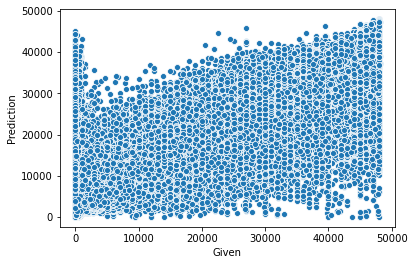

In [230]:
# plot k-fold predictions against actual
plot_k = sns.scatterplot(y, k_predictions)
plot_k.set(xlabel='Given', ylabel='Prediction')
# generate and graph y = x line
x_plot = np.linspace(0,5,100)
y_plot = np.linspace(0,5,100)
#plt.plot(x_plot, y_plot, color='y')

In [225]:
mean_squared_error(y, k_predictions)

41083069.57138299

-41083069.571383


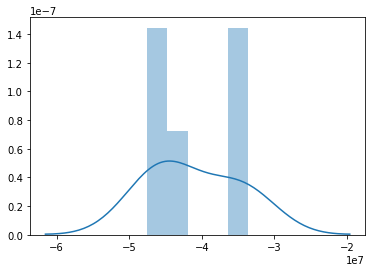

In [231]:
# find the mean score from the k-fold models usinf cross_val_score
kfold_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print(kfold_scores.mean())
# plot scores
sns.distplot(kfold_scores, bins=5)